In [21]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.utils import is_undirected, to_networkx, degree
import networkx as nx
from DatasetManager import DatasetManager
from torch_geometric.datasets import Planetoid, Twitch
from torch_geometric.utils import to_networkx

In [22]:
# --- Data Loading and Processing ---
csv_files = glob.glob('results/datasets/*.csv')
all_data = []
for f in csv_files:
    try:
        # Extract dataset name from the folder path
        dataset_name = f.split('_')[0].split('/')[-1]
        
        df = pd.read_csv(f)
        df['dataset_name'] = dataset_name
        all_data.append(df)
    except pd.errors.EmptyDataError:
        print(f"Warning: The file {f} is empty and will be skipped.")

full_df = pd.concat(all_data, ignore_index=True)
metric_cols = ['AUC', 'MRR', 'Hits@10', 'Hits@50', 'Hits@100']
for col in metric_cols:
    full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

full_df.dropna(subset=metric_cols, inplace=True)
avg_df = full_df.groupby(['dataset_name', 'model_name'])[metric_cols].mean().reset_index()

avg_df

,dataset_name,model_name,AUC,MRR,Hits@10,Hits@50,Hits@100
0,Citeseer,AdamicAdarModel,0.6445,0.1843,0.2933,0.2933,0.2933
1,Citeseer,CommonNeighborsModel,0.6444,0.1136,0.2933,0.2933,0.2933
2,Citeseer,DecisionTreeModel,0.7122,0.0787,0.3680,0.5073,0.5205
3,Citeseer,GCNModel1,0.7482,0.0642,0.1202,0.3314,0.5337
4,Citeseer,GCNModel2,0.9244,0.3905,0.5660,0.7375,0.8270
5,Citeseer,GraphSAGEModel1,0.5966,0.0740,0.1628,0.3050,0.3798
6,Citeseer,GraphSAGEModel2,0.8611,0.2445,0.4340,0.5484,0.6041
7,Citeseer,JaccardIndexModel,0.6446,0.1645,0.2933,0.2933,0.2933
8,Citeseer,KNNModel,0.7202,0.0773,0.4604,0.5029,0.5308
9,Citeseer,LogisticRegressionModel,0.6413,0.2212,0.4062,0.5059,0.5264


In [23]:
datasets_to_analyze = sorted(avg_df['dataset_name'].unique()) if not avg_df.empty else []
print(f"Ready to analyze {len(datasets_to_analyze)} datasets: {datasets_to_analyze}")

Ready to analyze 4 datasets: ['Citeseer', 'Cora', 'Twitch-DE', 'Twitch-EN']


In [24]:
network_stats = []
datasets_to_analyze = sorted(avg_df['dataset_name'].unique()) if not avg_df.empty else []

print(f"Analyzing {len(datasets_to_analyze)} datasets to gather network statistics...")

for dataset_name in datasets_to_analyze:
    print(f"  - Processing {dataset_name}...")
    
    path = '/tmp/'
    if dataset_name.lower().startswith('twitch'):
        country_code = dataset_name.split('-')[-1].upper()
        dataset = Twitch(root=path + "Twitch", name=country_code)
    elif dataset_name.lower() in ['cora', 'citeseer', 'pubmed']:
        dataset = Planetoid(root=path + dataset_name, name=dataset_name)
    else:
        print(f"    Warning: Skipping '{dataset_name}', direct loading not configured.")
        continue

    full_graph_data = dataset[0]
    
    G = to_networkx(full_graph_data, to_undirected=True)
    
    num_nodes = full_graph_data.num_nodes
    num_edges = full_graph_data.num_edges
    
    stats_dict = {
        'Dataset': dataset_name,
        'Nodes': num_nodes,
        'Edges': num_edges,
        'Avg. Node Degree': (2 * num_edges) / num_nodes, # 2*E/N for undirected
        'Node Feature Dim.': full_graph_data.num_features,
        'Density': nx.density(G),
        'Is Connected': nx.is_connected(G),
        '# Components': nx.number_connected_components(G)
    }
    network_stats.append(stats_dict)

stats_df = pd.DataFrame(network_stats).set_index('Dataset')
display(stats_df.style.format({
    'Avg. Node Degree': '{:.2f}',
    'Density': '{:.6f}'
}))


Analyzing 4 datasets to gather network statistics...
  - Processing Citeseer...
  - Processing Cora...
  - Processing Twitch-DE...
  - Processing Twitch-EN...


,Nodes,Edges,Avg. Node Degree,Node Feature Dim.,Density,Is Connected,# Components
Dataset,,,,,,,
Citeseer,3327,9104,5.47,3703,0.000823,False,438
Cora,2708,10556,7.80,1433,0.001440,False,78
Twitch-DE,9498,315774,66.49,128,0.003606,True,1
Twitch-EN,7126,77774,21.83,128,0.001672,True,1


In [25]:
def plot_metrics(dataset_name):
    save_fig = True
    dataset_results_df = avg_df[avg_df['dataset_name'] == dataset_name].sort_values(by='AUC', ascending=False)
 
    melted_df = dataset_results_df.melt(
        id_vars=['dataset_name', 'model_name'],
        value_vars=metric_cols,
        var_name='Metric',
        value_name='Score'
    )

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(25, 8))

    barplot = sns.barplot(
        data=melted_df,
        x='model_name',
        y='Score',
        hue='Metric',
        ax=ax,
        palette='magma'
    )

    ax.set_title(f'Model Performance on {dataset_name} Dataset', fontsize=22, pad=20)
    ax.set_xlabel('Model', fontsize=16, labelpad=15)
    ax.set_ylabel('Score', fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 1.05)
    
    for p in barplot.patches:
        if p.get_height() > 0.01:
            barplot.annotate(format(p.get_height(), '.2f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 9),
                           textcoords = 'offset points',
                           fontsize=9)

    plt.legend(title='Metric', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    if save_fig:
        fig.savefig(f'results/plots/{dataset_name}_model_performance.png', bbox_inches='tight')
    plt.show()

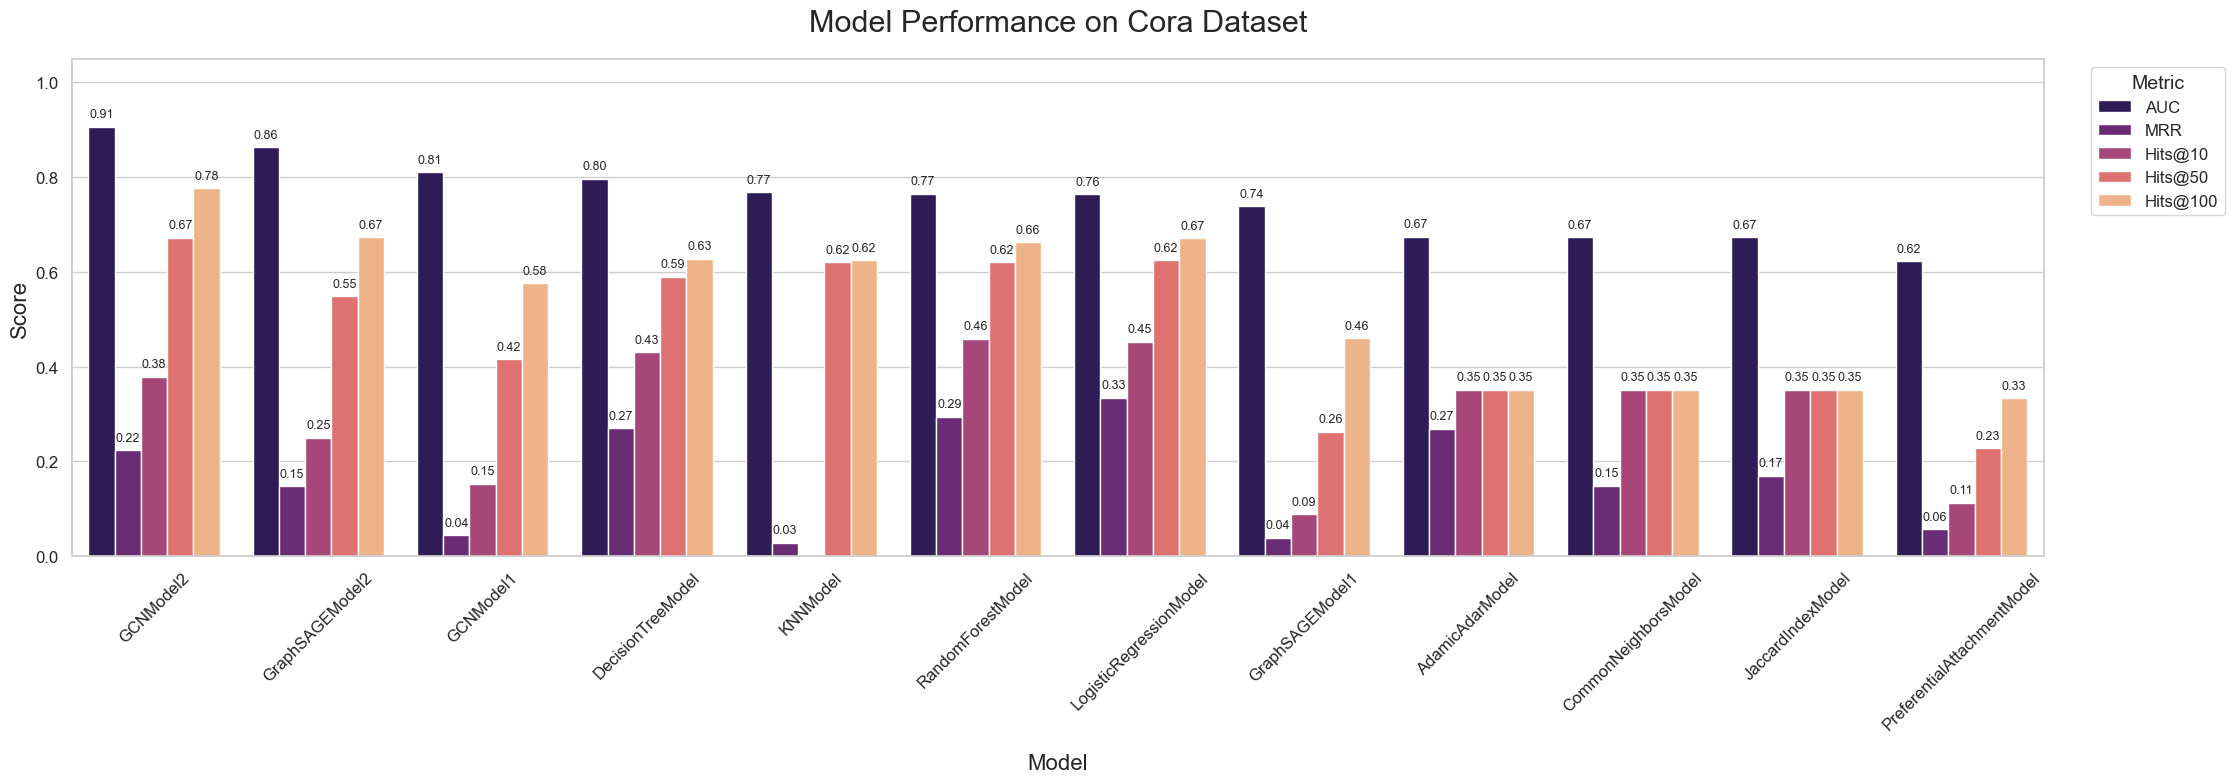

In [26]:
# --- 2. Plotting the model evaluation results ---
plot_metrics('Cora')

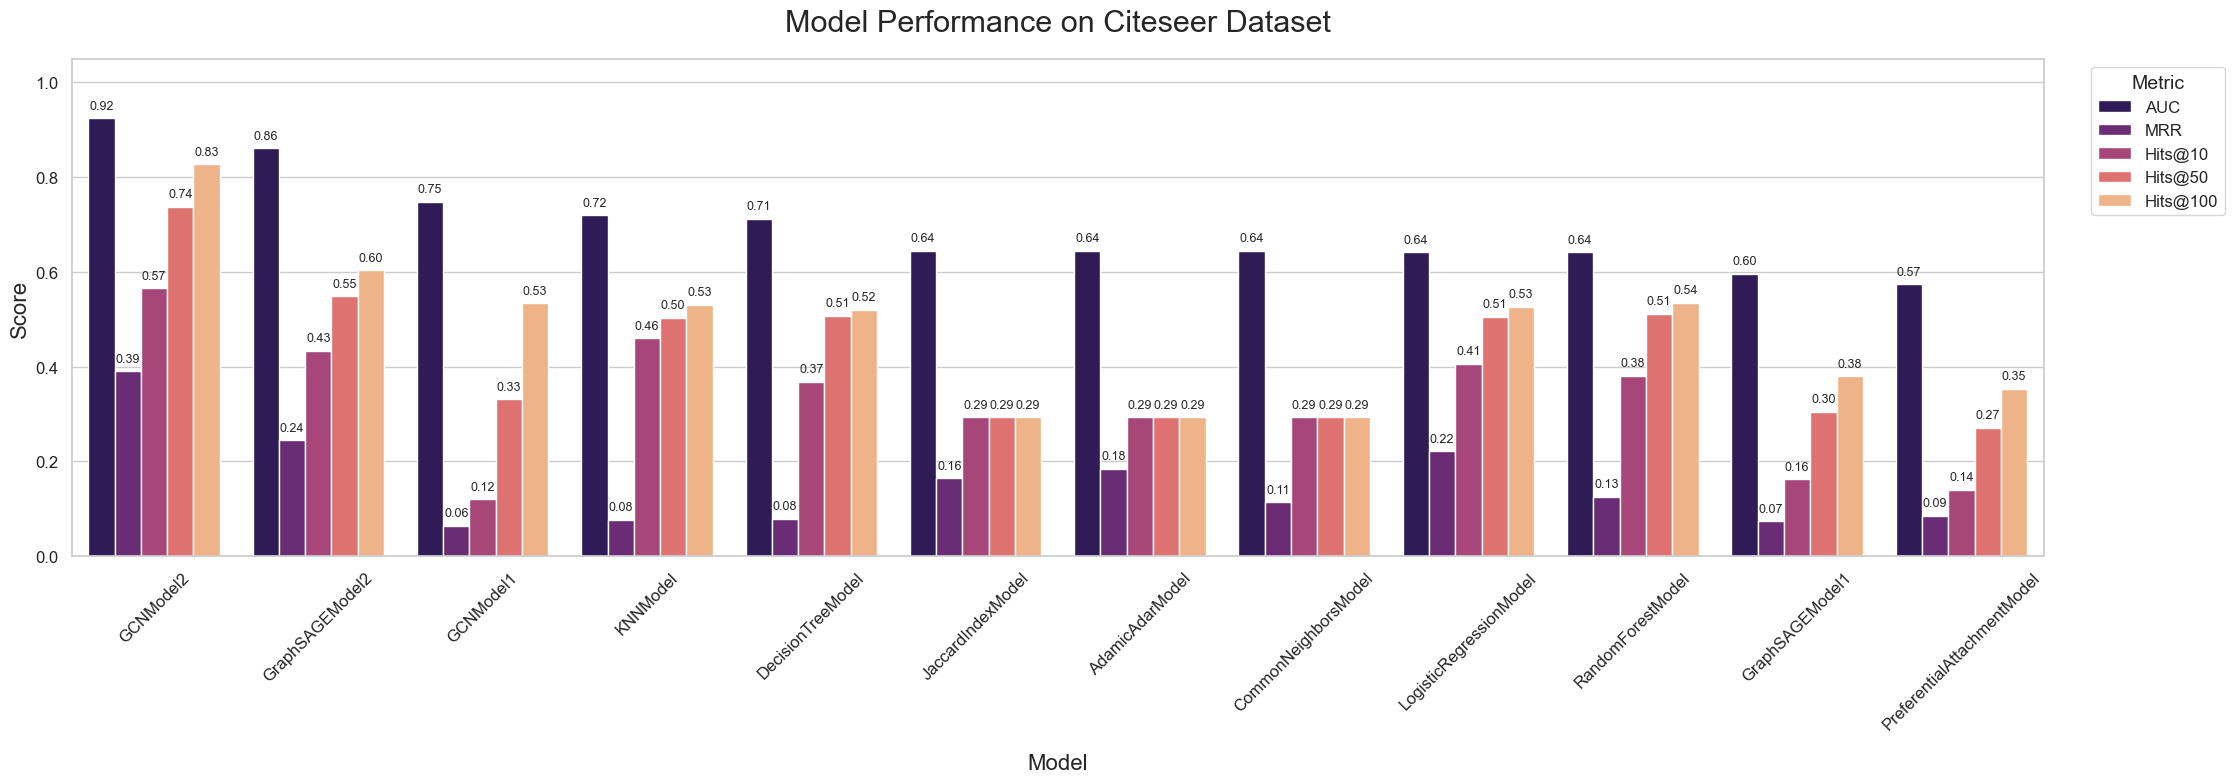

In [27]:
plot_metrics('Citeseer')

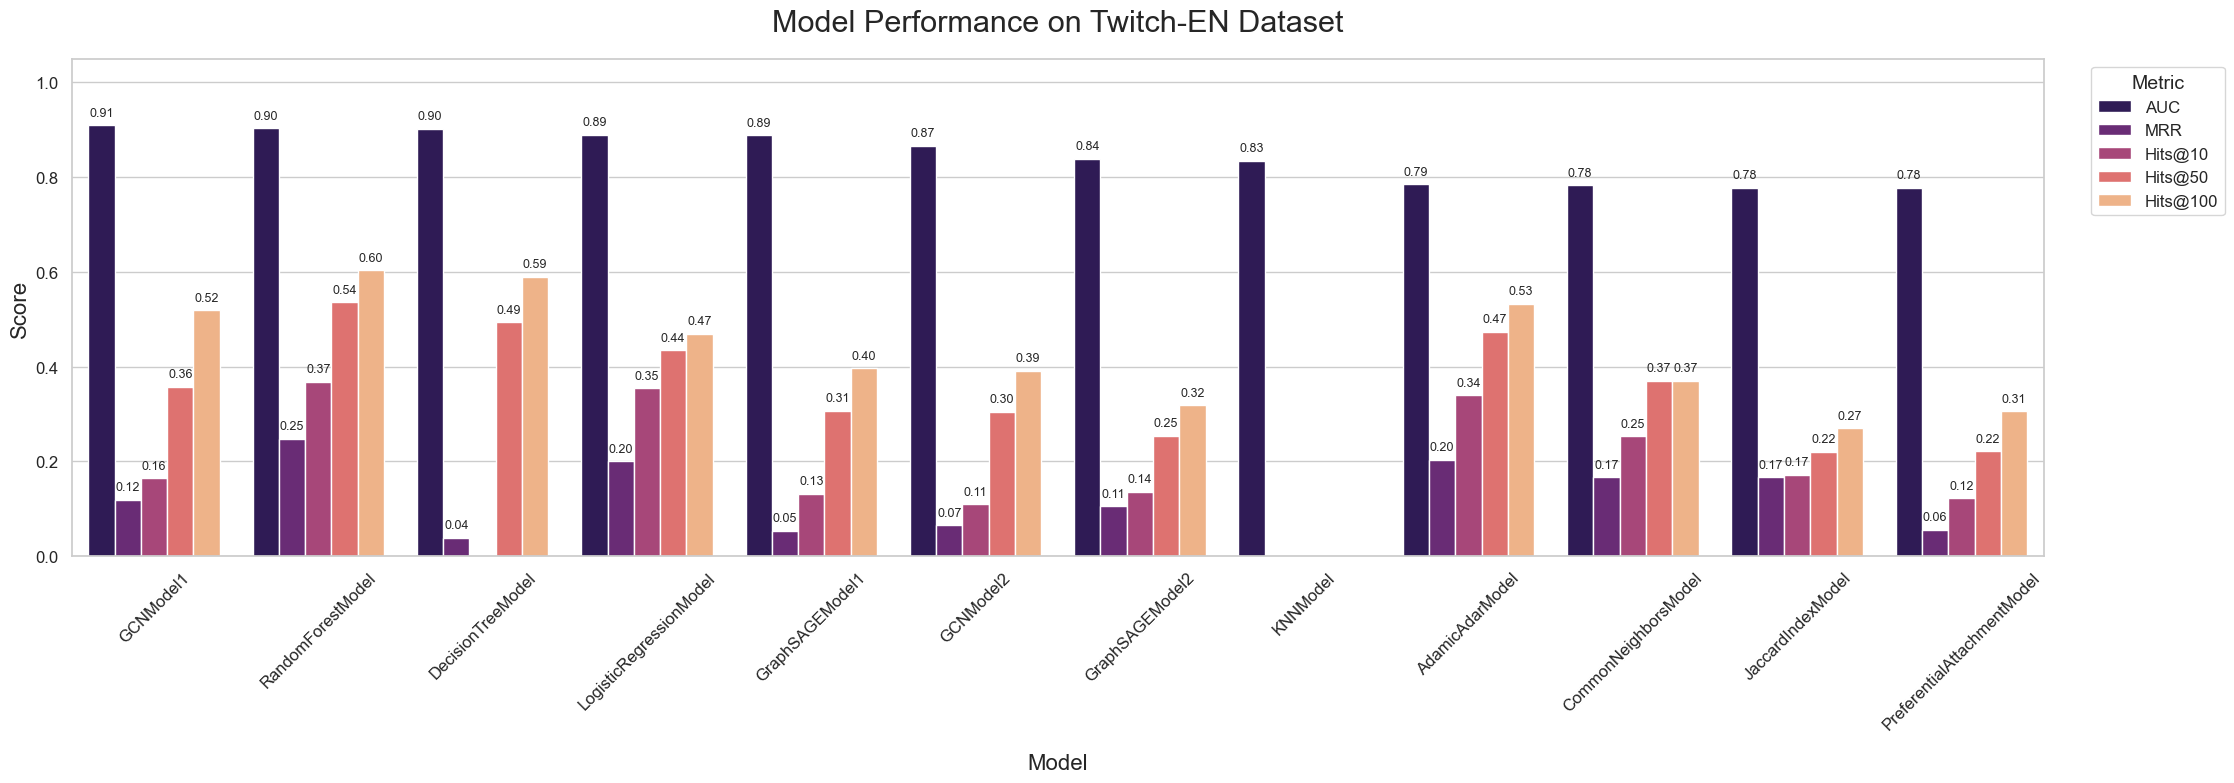

In [28]:
plot_metrics("Twitch-EN")

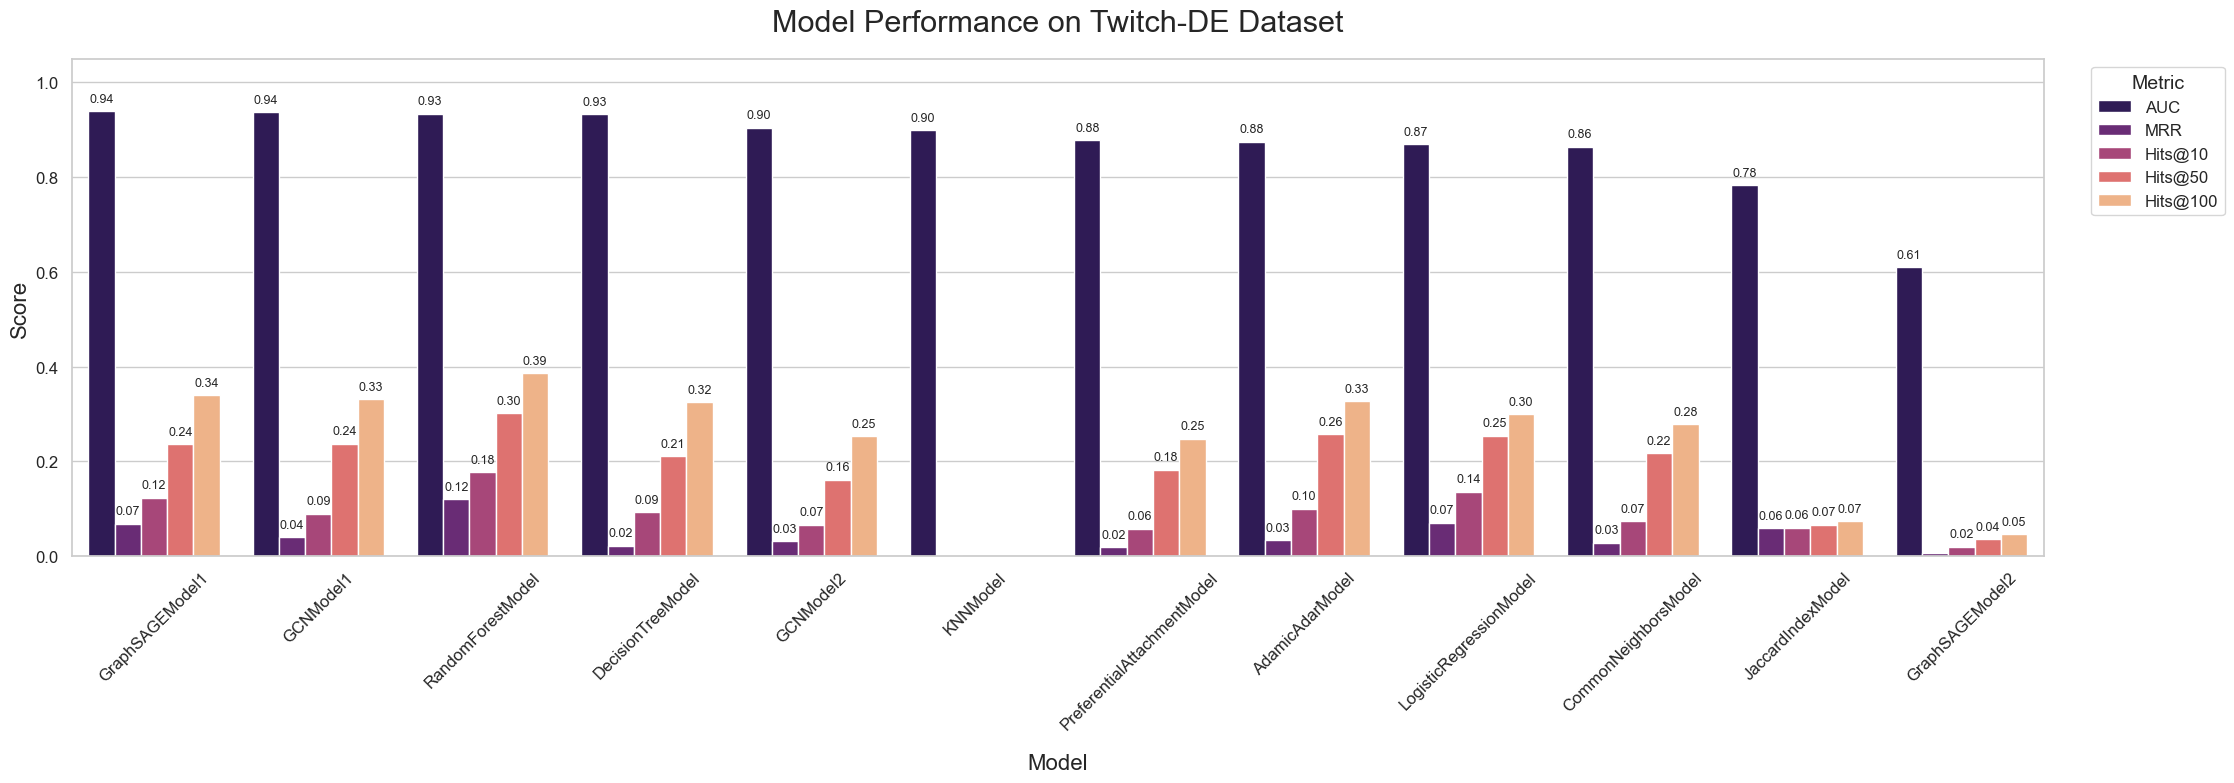

In [29]:
plot_metrics('Twitch-DE')